In [1]:
!nvidia-smi

Fri Oct 23 20:22:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shivamshrirao","key":"ea28047f0ee8776e2f6b3ecac0854b6f"}'}

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
!mkdir  ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [11]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:18<00:00, 90.8MB/s]
100% 1.33G/1.33G [00:19<00:00, 74.9MB/s]


In [12]:
!unzip -q celeba-dataset.zip

In [13]:
!rm celeba-dataset.zip

In [14]:
%load_ext tensorboard

In [15]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image

In [16]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 64

In [17]:
def load(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_image(img, channels=3, expand_animations = False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.image.random_flip_left_right(img)
    return img*2 - 1

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [19]:
dataset = tf.data.Dataset.list_files("/content/img_align_celeba/img_align_celeba/*")
dataset = dataset.shuffle(len(dataset))
dataset = dataset.map(load, num_parallel_calls=AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)

In [20]:
noise_dim = 128

## Using different weight initializer didin't help.

In [21]:
def upsample(x, nfilters, bn=True, drpo=True):
    x = layers.Conv2DTranspose(nfilters, kernel_size=(4,4), strides=(2,2), padding='same', use_bias=False)(x)
    if bn:
        x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    if drpo:
        x = layers.Dropout(0.3)(x)
    return x

def get_generator():
    inp = layers.Input(shape = (noise_dim,))

    x = layers.Dense(4*4*512, use_bias=False)(inp)
    x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Reshape((4,4,512))(x) # (4, 4, 512)

    x = upsample(x, 512)             # (8, 8, 512)
    x = upsample(x, 256)             # (16, 16, 256)
    x = upsample(x, 128)             # (32, 32, 128)
    x = upsample(x, 64, drpo=False)  # (64, 64, 64)

    x = layers.Conv2DTranspose(3, kernel_size=(4,4), strides=(2,2), padding='same')(x)
    x = layers.Activation('tanh')(x) # (128, 128, 3)

    model = tf.keras.Model(inputs=inp, outputs=x)
    return model

In [22]:
g = get_generator()
g.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 8192)              1048576   
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
re_lu (ReLU)                 (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)        

## Adding noise to discriminator prolly has best effect and faster training.

In [23]:
def downsample(x, nfilters, bn=True, strides=(2,2)):
    x = layers.GaussianNoise(0.1)(x)
    x = layers.Conv2D(nfilters, kernel_size=(4,4), strides=strides, padding='same', use_bias=False)(x)
    if bn:
        x = layers.BatchNormalization(momentum=0.9)(x)
    x = layers.LeakyReLU()(x)
    return x

def get_discriminator():
    inp = layers.Input(shape=(128,128,3))

    x = downsample(inp, 32, bn=False, strides=(1,1)) # (128, 128, 32)
    x = downsample(x, 64)               # (64, 64, 64)
    x = downsample(x, 128)              # (32, 32, 128)
    x = downsample(x, 256)              # (16, 16, 256)
    x = downsample(x, 512)              # (8, 8, 512)

    x = layers.GaussianNoise(0.1)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inp, outputs=x)
    return model

In [24]:
d = get_discriminator()
d.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      1536      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 128, 32)      0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        32768     
_________________________________________________________________
batch_normalization_5 (Batch (None, 64, 64, 64)       

In [25]:
criterion = tf.keras.losses.BinaryCrossentropy()

In [26]:
def discriminator_loss(real_output, fake_output):
    # real_loss = criterion(tf.ones_like(real_output), real_output)
    # fake_loss = criterion(tf.zeros_like(fake_output), fake_output)
    real_loss = criterion(tf.random.uniform(real_output.shape, minval=0.9, maxval=1), real_output)
    fake_loss = criterion(tf.random.uniform(fake_output.shape, minval=0, maxval=0.1), fake_output)
    return real_loss + fake_loss

In [27]:
def generator_loss(fake_output):
    return criterion(tf.ones_like(fake_output), fake_output)
    # return criterion(tf.random.uniform(fake_output.shape, minval=0.9, maxval=1), fake_output)

In [28]:
gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [29]:
import os
from time import time
from datetime import datetime

checkpoint_dir = '/content/drive/My Drive/training_checkpoints'
checkpoint = tf.train.Checkpoint(gen_opt=gen_opt, disc_opt=disc_opt, g=g, d=d)
manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=5)
manager.restore_or_initialize()

'/content/drive/My Drive/training_checkpoints/ckpt-32'

In [ ]:
!rm -rf logs/scalars/*

In [30]:
!cp -r /content/drive/My\ Drive/face_gan_logs/ logs

In [31]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
gen_writer = tf.summary.create_file_writer(logdir + "/generator")
disc_writer = tf.summary.create_file_writer(logdir + "/discriminator")
image_writer = tf.summary.create_file_writer(logdir + "/images")

In [32]:
tb_callback = tf.keras.callbacks.TensorBoard(logdir)
tb_callback.set_model(tf.keras.Sequential([g,d]))

In [33]:
seed = tf.random.normal([16, noise_dim])

In [34]:
!mkdir timelapse

In [35]:
def gen_grid(gen, show=True, save=False, nrows=4, ncols=4, figsize=[15,15]):
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize,gridspec_kw = {'wspace':0, 'hspace':0})
    fig.patch.set_facecolor('white')
    for i,axi in enumerate(ax.flat):
        axi.axis("off")
        axi.imshow(gen[i])
    fpath = None
    if save:
        fpath = "./timelapse/"+str(int(time()))+".png"
        fig.savefig(fpath, bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close(fig)
    return fpath

In [36]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = g(noise, training=True)

        real_output = d(images, training=True)
        fake_output = d(generated, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    gen_grads = gen_tape.gradient(gen_loss, g.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, d.trainable_variables)

    gen_opt.apply_gradients(zip(gen_grads, g.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grads, d.trainable_variables))
    return gen_loss, disc_loss

In [ ]:
!rm timelapse/*

rm: cannot remove 'timelapse/*': No such file or directory


In [ ]:
%tensorboard --logdir logs/scalars

In [39]:
GLOBAL_STEPS = 0

In [38]:
def train(dataset):
    global GLOBAL_STEPS
    steps = len(dataset)
    start = time()
    i=0
    for batch in dataset:
        gen_loss, disc_loss = train_step(batch)
        GLOBAL_STEPS+=1
        with gen_writer.as_default():
            tf.summary.scalar('loss', data=gen_loss, step=GLOBAL_STEPS)
        with disc_writer.as_default():
            tf.summary.scalar('loss', data=disc_loss, step=GLOBAL_STEPS)
        if not i%100:
            print(f"\r{i}/{steps}\t Time: {time()-start:.2f}s\t Gen Loss: {gen_loss:.5f}\t Desc Loss: {disc_loss:.5f}", end="    ")
            if i and (not i%1_500):
                noise = tf.random.normal([10, noise_dim])
                gen = g(noise, training=False)
                gen = (gen+1)/2
                with image_writer.as_default():
                    tf.summary.image("Random", gen, max_outputs=16, step=GLOBAL_STEPS)
                cnv = np.hstack(gen[:4].numpy())
                fig = plt.figure(figsize=[15, 15*4])
                plt.imshow(cnv)
                plt.axis('off')
                plt.show()
            if not i%1_000:
                gen = g(seed, training=False)
                gen = (gen+1)/2
                fpath = gen_grid(gen, show=False, save=True)
                with image_writer.as_default():
                    img = tf.io.read_file(fpath)
                    img = tf.io.decode_image(img, channels=4)
                    tf.summary.image("Seed", tf.expand_dims(img, 0), max_outputs=16, step=GLOBAL_STEPS)
                print("\nGrid Saved.")
            if not i%7_000:
                manager.save()
                print("Checkpoint saved.")
        i+=1

In [ ]:
EPOCHS = 40
DECAY_IN = 40
decay_rate = 0.1/DECAY_IN

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1} of {EPOCHS}.")
    train(dataset)
    for lyr in d.layers:
        if type(lyr) == layers.GaussianNoise:
            if lyr.stddev > 0:
                lyr.stddev -= decay_rate
            else:
                lyr.stddev = 0
manager.save()
print("\nCheckpoint saved.")

In [128]:
manager.checkpoints

['/content/drive/My Drive/training_checkpoints/ckpt-53',
 '/content/drive/My Drive/training_checkpoints/ckpt-54',
 '/content/drive/My Drive/training_checkpoints/ckpt-55',
 '/content/drive/My Drive/training_checkpoints/ckpt-56',
 '/content/drive/My Drive/training_checkpoints/ckpt-57']

In [151]:
checkpoint.restore(manager.checkpoints[0])

In [152]:
checkpoint.save("/content/drive/My Drive/face_gan_ckpt/ckpt")

'/content/drive/My Drive/face_gan_ckpt/ckpt-54'

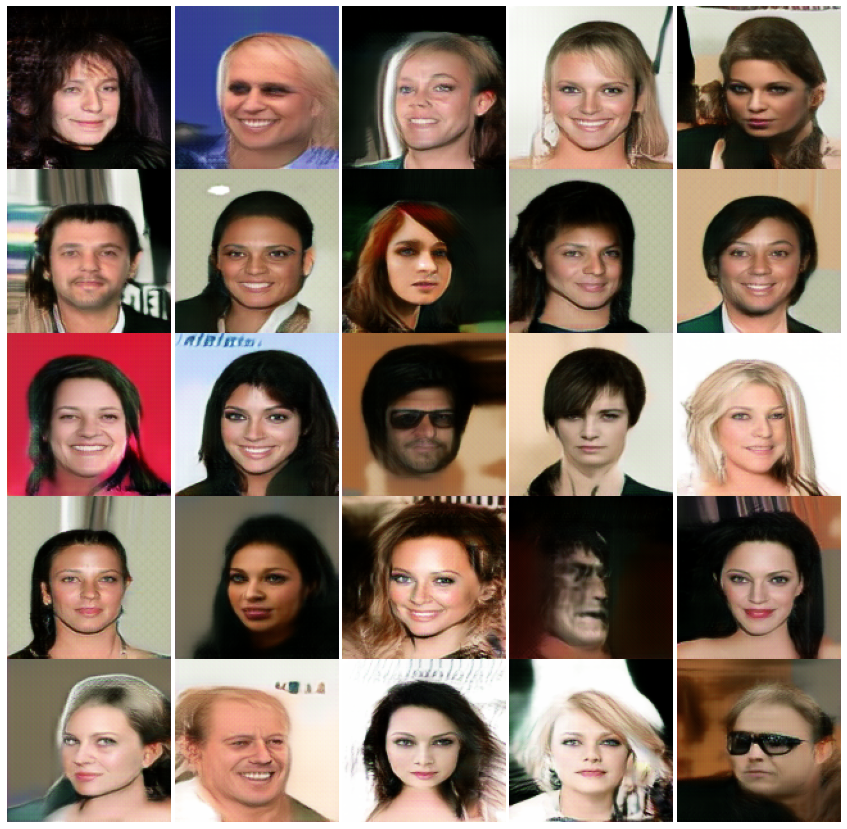

In [165]:
noise = tf.random.normal([25, noise_dim])
gen = g(noise, training=False)
gen_grid((gen+1)/2, show=True, save=False, nrows=5, ncols=5)

In [46]:
import glob
import imageio

In [47]:
def interpolate(p1, p2, n=10):
    path = tf.linspace(p1, p2, n)
    gen = g(path, training=False)
    cnv = np.hstack(gen)
    plt.figure(figsize=(4*n,4))
    plt.imshow((cnv+1)/2)
    plt.axis('off')
    plt.show()
    with imageio.get_writer('interpolate.gif', mode='I', fps=2) as writer:
        images = tf.cast(((gen+1)*127.5), tf.uint8).numpy()
        for img in images:
            writer.append_data(img)

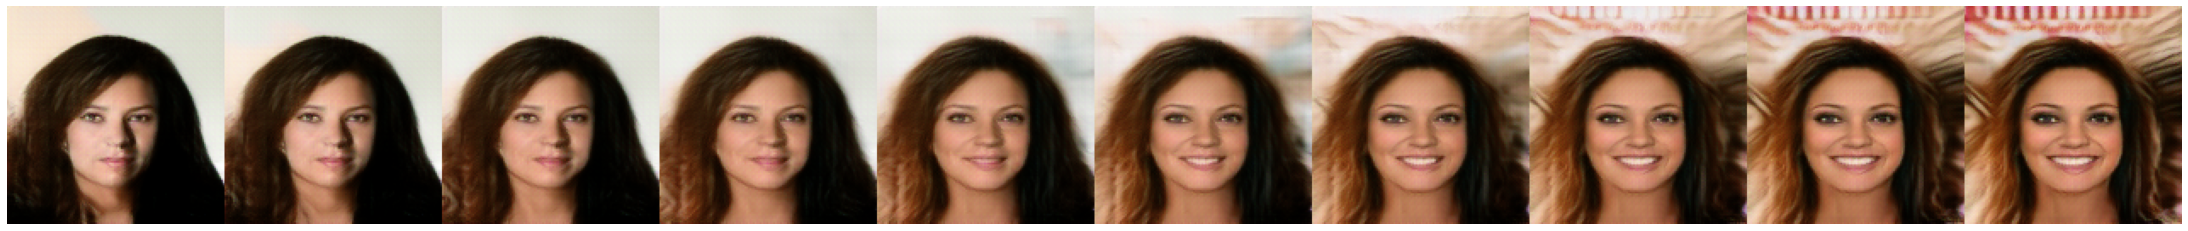

In [162]:
interpolate(tf.random.normal([noise_dim]), tf.random.normal([noise_dim]), 10)

In [49]:
class get_interpolate:
    def __init__(self, n=15, intrvl=60):
        self.n = n
        self.intrvl = intrvl
        self.i = 0
        self.stt = self.p1 = tf.random.normal([noise_dim])

    def next(self):
        if self.i == self.n-1:
            self.p2 = self.stt
        else:
            self.p2 = tf.random.normal([noise_dim])
        gen = g(tf.linspace(self.p1, self.p2, self.intrvl), training=False)
        self.p1 = self.p2
        self.i = (self.i+1)%self.n
        return gen

In [156]:
n = 12
polaters = [get_interpolate(n) for i in range(9)]
with imageio.get_writer('interpolate_anim_loop.gif', mode='I', fps=16) as writer:
    for i in range(n):
        print(f"\r{i+1}/{n}", end = " ")
        images = [tf.cast(((polater.next()+1)*127.5), tf.uint8).numpy() for polater in polaters]
        col_1 = np.hstack(images[:3])
        col_2 = np.hstack(images[3:6])
        col_3 = np.hstack(images[6:])
        mat = np.concatenate((col_1, col_2, col_3), axis=2)
        for img in mat:
            writer.append_data(img)

12/12 

In [157]:
!cp interpolate_anim_loop.gif /content/drive/My\ Drive/interpolate_anim_loop.gif

In [153]:
!cp -r logs /content/drive/My\ Drive/face_gan_logs

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I', fps=3) as writer:
    filenames = glob.glob('timelapse/*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

In [ ]:
!cp dcgan.gif /content/drive/My\ Drive/dcgan.gif